In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import requests
import datetime
from datetime import date
import calendar
import io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# Downloading the csv file from a Github page which has a list of companies and when they were added or removed from S&P 500
url = "https://raw.githubusercontent.com/leosmigel/analyzingalpha/master/sp500-historical-components-and-changes/sp500_history.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
df = pd.read_csv(io.StringIO(download.decode('utf-8')))

#Turning the date column into a datetime object
df["date"] = pd.to_datetime(df["date"])

# Printing out the first 5 rows of the dataframe
df.head()

,Unnamed: 0,cik,date,name,value,variable
0,183,72741.0,1957-01-01,Eversource Energy,ES,added_ticker
1,228,874766.0,1957-01-01,Hartford Financial Svc.Gp.,HIG,added_ticker
2,435,1113169.0,1957-01-01,T. Rowe Price Group,TROW,added_ticker
3,349,1111711.0,1957-01-01,NiSource Inc.,NI,added_ticker
4,185,1109357.0,1957-01-01,Exelon Corp.,EXC,added_ticker


In [3]:
# Function to retrieve the tickers in S&P 500 for a given timeframe
def past_SP_ticker(end_date):
    ticker_list = []
    global df
    for index,row in df.iterrows():
        if row['date'] > end_date:
            break
        else:
            if row['variable'] == "added_ticker":
                ticker_list.append(row['value'])
            elif row['value'] in ticker_list:
                ticker_list.remove(row['value'])
    return ticker_list

In [4]:
# Using the past_SP_ticker() function to retrieve the tickers of S&P 500 for 2017. 
end_date = '20171231'
date_time_obj = datetime.datetime.strptime(end_date,'%Y%m%d')
SP_ticker_2017 = past_SP_ticker(date_time_obj)

In [5]:
#Get return data
rawdata = yf.download(SP_ticker_2017, start="2013-12-31", end="2017-12-31")
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

[*********************100%***********************]  488 of 488 completed

33 Failed downloads:
- CXO: No data found, symbol may be delisted
- WCG: No data found, symbol may be delisted
- TYC: No data found for this date range, symbol may be delisted
- NBL: No data found, symbol may be delisted
- HCP: No data found, symbol may be delisted
- FOX: Data doesn't exist for startDate = 1388448000, endDate = 1514678400
- STI: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- ARNC: Data doesn't exist for startDate = 1388448000, endDate = 1514678400
- BBT: No data found, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- Q: No data found for this date range, symbol may be delisted
- LUK: No data found for this date range, symbol may be delisted
- JEC: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- GGP: No data found for this date range, symbol may be delisted
- FOXA: Data doesn't exi

Value       Adj Close                                                          \
Symbol              A        AAL         AAP       AAPL       ABBV        ABC   
Date                                                                            
2013-12-30        NaN        NaN         NaN        NaN        NaN        NaN   
2013-12-31  38.247646  23.804220  108.574318  17.819059  38.783775  62.277599   
2014-01-02  37.592243  23.907927  107.652184  17.568451  38.174229  61.905617   
2014-01-03  38.067078  25.020357  110.732445  17.182550  38.409229  61.949898   
2014-01-06  37.879810  25.482304  109.672997  17.276245  37.006523  61.728436   

Value                                                   ...     Volume  \
Symbol            ABT        ACN       ADBE        ADI  ...        XEL   
Date                                                    ...              
2013-12-30        NaN        NaN        NaN        NaN  ...        NaN   
2013-12-31  33.028294  71.508987  59.880001  42.778137  ...  1752800.0   
2014-01-02  32.942123  70.560982  59.290001  41.392246  ...  3192300.0   
2014-01-03  33.295418  70.795822  59.160000  41.669426  ...  2939400.0   
2014-01-06  33.734875  70.047867  58.119999  41.434235  ...  3382300.0   

Value                                                                         \
Symbol           XLNX         XOM       XRAY        XRX       XYL        YUM   
Date                                                                           
2013-12-30        NaN         NaN        NaN        NaN       NaN        NaN   
2013-12-31  1215400.0   8509600.0   434400.0  2033475.0  558000.0  2966864.0   
2014-01-02  3436800.0  11028100.0  1025400.0  3977691.0  765100.0  2721213.0   
2014-01-03  1982700.0   9295600.0   623300.0  2763747.0  454500.0  2026826.0   
2014-01-06  1970800.0  11848500.0   986700.0  5657131.0  849400.0  4083698.0   

Value                                        
Symbol            ZBH       ZION        ZTS  
Date                                         
2013-12-30        NaN        NaN        NaN  
2013-12-31   650000.0  1077400.0  2270400.0  
2014-01-02   868800.0  1356700.0  2576100.0  
2014-01-03  1288200.0  1122500.0  2524900.0  
2014-01-06  1414900.0  1988200.0  2763200.0  

[5 rows x 2928 columns]

Fill in Missing Values:

In [6]:
# Making an list of tuples for tickers that has more than 3 missing values
high_missing_ticker = rawdata['Adj Close'].isna().sum(axis=0) > 3
high_missing_ticker_list = high_missing_ticker[high_missing_ticker].index.tolist()
high_missing_ticker_tuples = list()
for i in ['Adj Close', 'Open', 'Close', 'High' ,'Low', 'Volume']:
    high_missing_ticker_tuples += list(zip([i]*len(high_missing_ticker_list),high_missing_ticker_list))

In [7]:
# Excluding columns (i.e., tickers) that has more than 3 missing values 
rawdata = rawdata.drop(high_missing_ticker_tuples, axis = 1)

In [8]:
# Finding out the dates that all tickers (columns) have missing values
missingdate =rawdata.isna().sum(axis=1) > 0
missingdate[missingdate].index

DatetimeIndex(['2013-12-30', '2015-09-22', '2017-09-01'], dtype='datetime64[ns]', name='Date', freq=None)

In [9]:
# row with the index of 2013-12-31 will be deleted as it is out of the scope of our data (2014~2017)
rawdata = rawdata.drop(pd.Timestamp('2013-12-30'))

In [10]:
# rows with the index of 2017-01-02 and 2017-02-20 are replaced with the values from the previous date
rawdata = rawdata.fillna(method= 'ffill')

In [11]:
#Create day index for dataframe
rawdata['Days of the Week'] = rawdata.index.dayofweek
rawdata.to_csv(r'Return Data by Date and Company.csv')

Only use close returns:

In [12]:
data = rawdata['Close']

#remove first row
data = data.iloc[1:]

Get Log Returns (which approximate to returns):

In [13]:
logret = np.log(data).diff()
logret.head()

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.012552,0.045480,0.028211,-0.022211,0.006137,0.000715,0.010667,0.003323,-0.002195,0.006674,...,-0.000364,-0.007643,-0.002409,0.004784,0.006695,0.009034,0.006240,0.004327,0.007058,-0.009626
2014-01-06,-0.004931,0.018294,-0.009614,0.005438,-0.037204,-0.003581,0.013112,-0.010621,-0.017736,-0.005660,...,-0.005469,-0.004394,0.001506,-0.006036,0.008306,-0.001742,-0.000794,0.006456,-0.007058,-0.002186
2014-01-07,0.014200,-0.004449,0.012268,-0.007177,0.001983,0.010846,-0.007692,0.012094,0.014519,0.005257,...,0.017039,0.002199,0.014049,0.015331,0.008237,0.002902,0.013942,0.019752,0.003031,0.003745
2014-01-08,0.016230,0.026404,-0.007806,0.006313,-0.002578,0.009747,0.008969,0.007699,-0.001188,0.002417,...,-0.003962,0.008531,-0.003270,0.001849,-0.009065,-0.000580,-0.000392,0.024205,0.008704,-0.011278


Plot average returns from 2014 - 2017

Text(0.5, 1.0, 'Average Return For All S&P500 Companies By Day for 2014-2017')

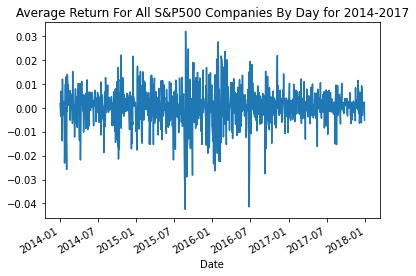

In [14]:
np.mean(logret, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Day for 2014-2017")

Make Date Index a Column and retrieve day of week, and drop columns that are not stocks:

In [15]:
logret['Day of Week'] = logret.index.dayofweek

In [16]:
groupeddata = logret.groupby('Day of Week')
mean_per_stock = groupeddata.mean()

mean_per_stock

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Day of Week,,,,,,,,,,,,,,,,,,,,,
0,-0.000728,-0.000018,-0.000295,0.002913,-0.000918,0.000392,-0.000081,0.000699,-0.000951,0.000875,...,0.000995,0.000945,-0.000242,-0.000991,-0.002276,-0.000489,-0.000372,-0.000683,-0.000763,-0.000907
1,0.000380,0.002416,-0.000299,0.000178,0.000190,0.001269,-0.000398,0.001155,0.001225,0.001676,...,0.000265,0.000828,0.000516,0.000973,0.000396,0.001177,0.001111,0.001135,0.000077,0.000608
2,0.002487,0.000540,-0.000321,0.001457,0.002305,0.002221,0.000684,0.000788,0.001616,0.002203,...,-0.000073,0.000580,0.000173,0.001152,0.001555,0.001078,-0.000137,0.000683,0.001687,0.001819
3,-0.000061,0.000526,0.000082,-0.000706,0.000871,-0.001834,0.001515,0.000679,0.001623,-0.001436,...,0.001567,-0.000450,-0.000125,0.000230,-0.000345,0.000939,-0.000257,-0.000294,0.000934,0.001525
4,0.000315,0.000016,0.000356,0.000082,0.000492,-0.000771,0.000248,-0.000182,0.001717,-0.000438,...,0.000079,0.000021,-0.001235,0.000076,0.000091,0.000626,0.001660,0.000395,0.000631,0.000790


Mean Across All Stocks Per Day:

In [17]:
np.mean(mean_per_stock, axis = 1)

Day of Week
0   -0.000104
1    0.000388
2    0.000960
3    0.000278
4    0.000306
dtype: float64

([<matplotlib.axis.XTick at 0x7fa7e9fbb700>,
 [Text(0, 0, 'Mon'),
  Text(1, 0, 'Tues'),
  Text(2, 0, 'Wed'),
  Text(3, 0, 'Thurs'),
  Text(4, 0, 'Fri')])

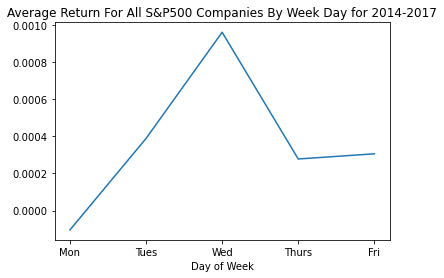

In [18]:
np.mean(mean_per_stock, axis = 1).plot()
plt.title("Average Return For All S&P500 Companies By Week Day for 2014-2017")
plt.xticks([0, 1, 2, 3, 4], ["Mon", "Tues", "Wed", "Thurs", "Fri"], rotation='horizontal')

Going by this plot alone, Mondays did have the lowest average returns. To see if the Monday average return is significantly lower than any other day, run an ANOVA test if mean returns of each day are significantly different.

In [19]:
fval, pval = stats.f_oneway(np.array(mean_per_stock.iloc[0].array), np.array(mean_per_stock.iloc[1].array), np.array(mean_per_stock.iloc[2].array), np.array(mean_per_stock.iloc[3].array), np.array(mean_per_stock.iloc[4].array))

pval

1.2807280794183247e-48

According to this test (assuming a significance level alpha = 0.05), the means across days are significantly different across the board. Next, see which day(s) is/are significantly different than the rest:

In [20]:
dfTukey = pd.DataFrame({'return': np.reshape(mean_per_stock.values, -1),
                   'day': np.repeat(mean_per_stock.index, repeats=len(mean_per_stock.iloc[1,:]))})

tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0005  0.001  0.0003  0.0007   True
     0      2   0.0011  0.001  0.0009  0.0013   True
     0      3   0.0004  0.001  0.0002  0.0006   True
     0      4   0.0004  0.001  0.0002  0.0006   True
     1      2   0.0006  0.001  0.0004  0.0008   True
     1      3  -0.0001 0.5037 -0.0003  0.0001  False
     1      4  -0.0001 0.7303 -0.0003  0.0001  False
     2      3  -0.0007  0.001 -0.0009 -0.0005   True
     2      4  -0.0007  0.001 -0.0008 -0.0005   True
     3      4      0.0    0.9 -0.0002  0.0002  False
----------------------------------------------------


For every Monday pairing, the p-value is significant. Thus, we should reject the null hypothesis that the means of Monday and any other day are the same. However, the same claim can be made for every Wednesday pairing. However, Wednesday is likely significantly higher than any other day, as the average returns on Wednesday is the "peak" in the plot, whereas Monday, having the lowest average returns, are likely significantly lower than any other day.

Next, see if if there is a similar trend by month by testing if January has significantly lower returns than any other month.

In [21]:
logret['Month of Year'] = logret.index.month

groupeddata = logret.groupby('Month of Year')
mean_per_stock_month = groupeddata.mean()

mean_per_stock_month

Symbol,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS,Day of Week
Month of Year,,,,,,,,,,,,,,,,,,,,,
1,-0.001004,0.000695,0.000308,-0.000908,-0.002985,-0.000289,-0.001708,-0.001200,0.000079,-0.001005,...,-0.000939,-0.002653,-0.001926,-0.000560,-0.001940,-0.001200,0.001401,-0.005190,-0.001924,2.150000
2,0.001668,0.002188,0.000081,0.003332,0.000553,0.001315,0.003089,0.001730,0.003448,0.003126,...,0.002066,0.000706,0.002459,0.001366,0.002940,0.002749,0.000446,0.002493,0.000257,2.077922
3,0.000696,-0.000038,-0.000214,0.001763,0.000840,0.000372,0.000081,0.001299,0.000923,0.002602,...,0.000292,0.000275,-0.000370,0.001175,0.000401,0.000993,0.001391,0.000715,0.000144,1.954545
4,0.000346,-0.003554,-0.001911,-0.000613,0.002319,-0.001138,-0.001003,-0.000181,-0.000043,-0.002152,...,-0.001523,0.001541,-0.000606,-0.002618,0.001608,0.001331,0.000213,0.000728,0.001373,1.951220
5,0.003027,0.000578,0.000193,0.002799,0.001239,0.001021,0.001690,0.001537,0.002350,0.003233,...,0.002803,-0.000606,0.001483,0.000420,0.000724,0.002170,0.001937,0.000314,0.002866,2.083333
6,-0.001240,-0.000835,0.000401,-0.001301,0.001431,0.000252,0.000992,-0.000634,0.001123,-0.001782,...,-0.001462,0.000371,0.000120,-0.001115,0.001393,0.000852,0.000135,0.001235,0.000238,1.988506
7,0.001489,0.001573,-0.000105,0.001348,-0.000040,0.001371,0.002416,0.000956,0.000292,-0.000553,...,-0.001319,-0.001519,0.000792,0.002931,-0.000969,-0.001007,-0.000675,0.001139,0.001179,2.023810
8,-0.000522,-0.001423,-0.000977,0.001277,-0.000212,-0.002100,-0.001563,-0.000378,0.001101,0.000267,...,0.001511,-0.001298,-0.002139,-0.000380,0.001636,-0.000236,-0.000956,-0.000072,0.000019,1.965909
9,-0.000783,-0.000328,-0.000100,-0.000457,0.000676,-0.001158,-0.000981,0.001657,0.000323,0.000441,...,0.001043,0.000062,-0.000709,-0.000337,0.000040,-0.000549,-0.000695,0.000447,-0.000117,2.108434


([<matplotlib.axis.XTick at 0x7fa7e9f7c8e0>,
 [Text(1, 0, 'Jan'),
  Text(2, 0, 'Feb'),
  Text(3, 0, 'Mar'),
  Text(4, 0, 'Apr'),
  Text(5, 0, 'May'),
  Text(6, 0, 'June'),
  Text(7, 0, 'July'),
  Text(8, 0, 'Aug'),
  Text(9, 0, 'Sept'),
  Text(10, 0, 'Oct'),
  Text(11, 0, 'Nov'),
  Text(12, 0, 'Dec')])

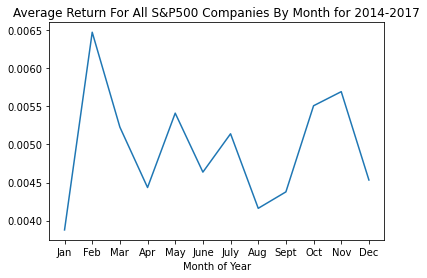

In [22]:
np.mean(mean_per_stock_month, axis = 1).plot()
#plt.ylim([70, 90])
plt.title("Average Return For All S&P500 Companies By Month for 2014-2017")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"], rotation='horizontal')

In [23]:
fval, pval = stats.f_oneway(np.array(mean_per_stock_month.iloc[0].array), np.array(mean_per_stock_month.iloc[1].array), np.array(mean_per_stock_month.iloc[2].array), np.array(mean_per_stock_month.iloc[3].array), np.array(mean_per_stock_month.iloc[4].array),np.array(mean_per_stock_month.iloc[5].array), np.array(mean_per_stock_month.iloc[6].array), np.array(mean_per_stock_month.iloc[7].array), np.array(mean_per_stock_month.iloc[8].array), np.array(mean_per_stock_month.iloc[9].array), np.array(mean_per_stock_month.iloc[10].array), np.array(mean_per_stock_month.iloc[11].array))
pval

0.9999999207069781

With a significance level alpha = 0.05, we fail to reject the null and can currently claim that there is no difference in returns across months.

In [24]:
groupeddata = logret.groupby(['Month of Year', 'Day of Week'])

mean_per_stock_months_and_days = groupeddata.mean()

mean_per_stock_months_and_days

Symbol                            A       AAL       AAP      AAPL      ABBV  \
Month of Year Day of Week                                                     
1             0           -0.007968 -0.013658 -0.001970 -0.002447 -0.012029   
              1            0.001254  0.007250  0.004488 -0.003428 -0.003402   
              2            0.001265  0.002927 -0.004339 -0.000035 -0.005824   
              3           -0.001953  0.009793 -0.000082  0.002174  0.007532   
              4            0.000334 -0.006000  0.002354 -0.001019 -0.003386   
2             0           -0.003757  0.003040 -0.006739  0.007491 -0.006016   
              1            0.005716 -0.003554  0.002272  0.003362  0.006172   
              2            0.006397  0.004410 -0.003139  0.006618 -0.000402   
              3            0.001213  0.005484  0.004623  0.001869  0.003199   
              4           -0.002247  0.001721  0.002108 -0.001900 -0.001418   
3             0            0.002021  0.002376 -0.000681  0.003938 -0.000225   
              1           -0.003965 -0.001182 -0.002179  0.005796  0.003830   
              2            0.004575 -0.001540  0.000088  0.001205  0.001932   
              3           -0.001584 -0.004594  0.001975 -0.002083 -0.001886   
              4            0.002651  0.005348 -0.000282 -0.000265  0.000510   
4             0           -0.000991 -0.001128 -0.003002  0.005805  0.004143   
              1            0.000238  0.004525  0.000593 -0.002893  0.004345   
              2            0.005085  0.003102  0.001814 -0.002994  0.003926   
              3           -0.000458 -0.010120 -0.006430  0.000245 -0.001309   
              4           -0.003112 -0.016723 -0.003010 -0.003159  0.000116   
5             0            0.006035  0.005740  0.001005  0.009732  0.004077   
              1            0.004082  0.002552 -0.006011 -0.000037 -0.001256   
              2            0.000589 -0.010236 -0.004443 -0.001905  0.002595   
              3            0.000884 -0.000244  0.006245  0.001708  0.000591   
              4            0.003960  0.005581  0.004426  0.005714  0.000858   
6             0           -0.005253 -0.005085 -0.000333 -0.001218 -0.006648   
              1            0.000870  0.000095 -0.000561  0.001845  0.001407   
              2            0.004084  0.006297 -0.000725  0.001824  0.006626   
              3            0.001220 -0.001123  0.001607 -0.001046  0.007085   
              4           -0.007028 -0.004093  0.001988 -0.007927 -0.001173   
7             0            0.000795 -0.002541  0.000702  0.004699  0.000017   
              1            0.002775  0.008429 -0.007284 -0.001159 -0.002736   
              2            0.002364 -0.002234 -0.003870  0.002523  0.003122   
              3           -0.001433 -0.000171  0.005799 -0.002510 -0.001848   
              4            0.003198  0.005076  0.003859  0.003525  0.001075   
8             0            0.001336  0.002798  0.000900  0.004502  0.001786   
              1           -0.004610 -0.001567 -0.016039 -0.002617 -0.003490   
              2            0.001781 -0.001973  0.003877  0.007666  0.001598   
              3           -0.003826 -0.005825  0.005769 -0.003976 -0.000210   
              4            0.002706 -0.000753  0.001100  0.000476 -0.000777   
9             0           -0.002881 -0.005069 -0.000251  0.000503 -0.011055   
              1           -0.000679 -0.000019 -0.002037 -0.000643 -0.001260   
              2            0.004998  0.005226  0.010265  0.003441  0.007106   
              3           -0.001481 -0.001060 -0.006213 -0.004833  0.005398   
              4           -0.004170 -0.001766 -0.002069 -0.000514  0.000551   
10            0            0.001160  0.004413 -0.002466  0.002468 -0.000060   
              1           -0.006353  0.012018  0.003651  0.004703 -0.003637   
              2            0.001321 -0.004849 -0.005287 -0.000182  0.003841   
              3            0.000912  0.006641 -0.0

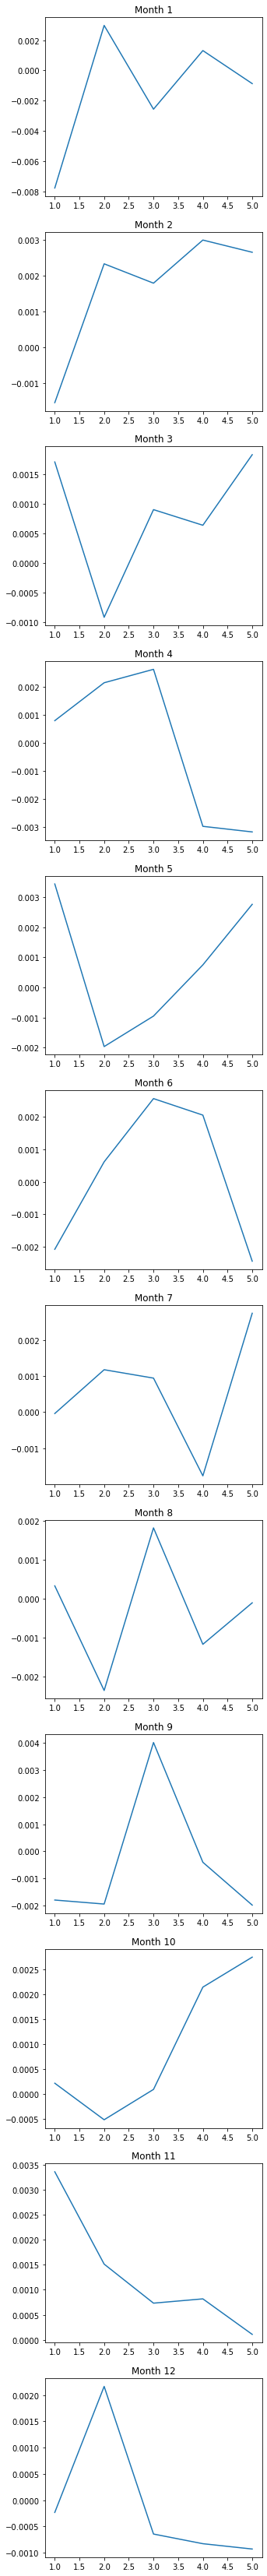

In [25]:
fig, ax = plt.subplots(12, 1, figsize=(5,60))
plt.title("Average Returns by Day by Month")

## Write a for loop
for i in range(1,13):
    temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
    ax[i-1].plot(range(1,6), np.mean(temp_mean_per_stock, axis = 1).values)
    ax[i-1].set_title('Month %i' % (i))

In [26]:
pvals_months = []

for i in range(1,13):
        temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
        fval, pval = stats.f_oneway(np.array(temp_mean_per_stock.iloc[0].array), np.array(temp_mean_per_stock.iloc[1].array), np.array(temp_mean_per_stock.iloc[2].array), np.array(temp_mean_per_stock.iloc[3].array), np.array(temp_mean_per_stock.iloc[4].array))
        pvals_months.append(pval)
        
pvals_months

[3.56667967596312e-255,
 3.015692111009348e-78,
 9.949883438639523e-56,
 3.007054237135294e-175,
 3.3811077210640442e-152,
 1.9441046064773953e-190,
 8.466172187096405e-94,
 2.2863098466905667e-95,
 1.8228737280152316e-226,
 6.564012848862093e-60,
 1.713448509990251e-35,
 7.703224470037321e-55]

With a significant level of alpha = 0.05, we reject the null for each month, so within each month, the average returns vary significantly across days.

In [27]:
for i in range(1,13):
    print('Month %i' % (i))
    temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
    dfTukey = pd.DataFrame({'return': np.reshape(temp_mean_per_stock.values, -1),
                   'day': np.repeat([0,1,2,3,4], repeats=len(temp_mean_per_stock.iloc[1,:]))})
    tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)
    print(tukey)

Month 1
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.0107 0.001  0.0099  0.0115   True
     0      2   0.0052 0.001  0.0044   0.006   True
     0      3   0.0091 0.001  0.0083  0.0099   True
     0      4   0.0069 0.001  0.0061  0.0077   True
     1      2  -0.0055 0.001 -0.0063 -0.0047   True
     1      3  -0.0017 0.001 -0.0025 -0.0009   True
     1      4  -0.0038 0.001 -0.0046  -0.003   True
     2      3   0.0039 0.001  0.0031  0.0047   True
     2      4   0.0017 0.001  0.0009  0.0025   True
     3      4  -0.0022 0.001  -0.003 -0.0014   True
---------------------------------------------------
Month 2
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0039  0.001  0.0032 0.0046   True
     0      2   0.0033  0.001  0.0026 0.0041   T

The months were Monday appears to be significantly different from other days at "higher rates" than other day-day pairings are February and November. Looking at the plots, Mondays in February have the lowest average returns, and Mondays in November have the highest average returns. Therefore, Monday returns do not behave the same across months, indicating that if there is a Monday effect, it is inconsistent across time.

Now, we analyze the Monday effect by industry. First, we subset by industry, and within each industry, we determine if the average returns vary across days.

In [28]:
import csv

#df = pd.read_csv('SP500_2014_2017_multilevel.csv', header=[0,1,2], index_col=0)
multilevel = pd.read_csv(r'/home/jovyan/work/SP500_2014_2017_multilevel.csv', header=[0,1,2], index_col=0)
multilevel.head()

Adj Close                              \
           Diagnostics & Research   Airlines Specialty Retail   
                                A        AAL              AAP   
Date                                                            
2014-01-02              37.592243  23.907927       107.652184   
2014-01-03              38.067078  25.020357       110.732445   
2014-01-06              37.879810  25.482304       109.672997   
2014-01-07              38.421539  25.369177       111.026726   
2014-01-08              39.050190  26.047951       110.163490   

                                                            \
           Consumer Electronics Drug Manufacturers—General   
                           AAPL                       ABBV   
Date                                                         
2014-01-02            17.568451                  38.174229   
2014-01-03            17.182550                  38.409229   
2014-01-06            17.276245                  37.006523   
2014-01-07            17.152693                  37.079971   
2014-01-08            17.261324                  36.984486   

                                                 \
           Medical Distribution Medical Devices   
                            ABC             ABT   
Date                                              
2014-01-02            61.905617       32.942123   
2014-01-03            61.949898       33.295418   
2014-01-06            61.728436       33.734875   
2014-01-07            62.401627       33.476364   
2014-01-08            63.012794       33.777969   

                                                                    \
           Information Technology Services Software—Infrastructure   
                                       ACN                    ADBE   
Date                                                                 
2014-01-02                       70.560982               59.290001   
2014-01-03                       70.795822               59.160000   
2014-01-06                       70.047867               58.119999   
2014-01-07                       70.900169               58.970001   
2014-01-08                       71.448112               58.900002   

                           ...      logreturn                       \
           Semiconductors  ... Semiconductors Oil & Gas Integrated   
                      ADI  ...           XLNX                  XOM   
Date                       ...                                       
2014-01-02      41.567257  ...       0.001088            -0.014432   
2014-01-03      41.845615  ...      -0.007643            -0.002409   
2014-01-06      41.609428  ...      -0.004394             0.001506   
2014-01-07      41.828735  ...       0.002199             0.014049   
2014-01-08      41.929951  ...       0.008531            -0.003270   

                                                                           \
           Medical Instruments & Supplies Information Technology Services   
                                     XRAY                             XRX   
Date                                                                        
2014-01-02                      -0.010784                       -0.021596   
2014-01-03                       0.004784                        0.006695   
2014-01-06                      -0.006036                        0.008306   
2014-01-07                       0.015331                        0.008237   
2014-01-08                       0.001849                       -0.009065   

                                                                       \
           Specialty Industrial Machinery Restaurants Medical Devices   
                                      XYL         YUM             ZBH   
Date                                                                    
2014-01-02                      -0.012798   -0.006901       -0.010247   
2014-01-03                       0.009034    0.006240        0.004327   
2014-01-06               

First of all, only want log returns:

In [29]:
multilevelLog = multilevel['logreturn']
multilevelLog.head()

,Diagnostics & Research,Airlines,Specialty Retail,Consumer Electronics,Drug Manufacturers—General,Medical Distribution,Medical Devices,Information Technology Services,Software—Infrastructure,Semiconductors,...,Utilities—Regulated Electric,Semiconductors,Oil & Gas Integrated,Medical Instruments & Supplies,Information Technology Services,Specialty Industrial Machinery,Restaurants,Medical Devices,Banks—Regional,Drug Manufacturers—Specialty & Generic
,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,-0.017284,0.004347,-0.008529,-0.014164,-0.015842,-0.005991,-0.002612,-0.013346,-0.009902,-0.032934,...,-0.015510,0.001088,-0.014432,-0.010784,-0.021596,-0.012798,-0.006901,-0.010247,-0.010401,-0.010146
2014-01-03,0.012552,0.045480,0.028211,-0.022211,0.006137,0.000715,0.010667,0.003323,-0.002195,0.006674,...,-0.000364,-0.007643,-0.002409,0.004784,0.006695,0.009034,0.006240,0.004327,0.007058,-0.009626
2014-01-06,-0.004931,0.018294,-0.009614,0.005438,-0.037204,-0.003581,0.013112,-0.010621,-0.017736,-0.005660,...,-0.005469,-0.004394,0.001506,-0.006036,0.008306,-0.001742,-0.000794,0.006456,-0.007058,-0.002186
2014-01-07,0.014200,-0.004449,0.012268,-0.007177,0.001983,0.010846,-0.007692,0.012094,0.014519,0.005257,...,0.017039,0.002199,0.014049,0.015331,0.008237,0.002902,0.013942,0.019752,0.003031,0.003745
2014-01-08,0.016230,0.026404,-0.007806,0.006313,-0.002578,0.009747,0.008969,0.007699,-0.001188,0.002417,...,-0.003962,0.008531,-0.003270,0.001849,-0.009065,-0.000580,-0.000392,0.024205,0.008704,-0.011278


Repopulate Day Column

In [30]:
industries = np.unique(multilevelLog.columns.get_level_values(0))[:-1] #-1 removes nan
industries

array(['Advertising Agencies', 'Aerospace & Defense',
       'Agricultural Inputs', 'Airlines', 'Apparel Manufacturing',
       'Apparel Retail', 'Asset Management', 'Auto & Truck Dealerships',
       'Auto Manufacturers', 'Auto Parts', 'Banks—Diversified',
       'Banks—Regional', 'Beverages—Brewers', 'Beverages—Non-Alcoholic',
       'Beverages—Wineries & Distilleries', 'Biotechnology',
       'Broadcasting', 'Building Materials',
       'Building Products & Equipment', 'Business Equipment & Supplies',
       'Capital Markets', 'Chemicals', 'Communication Equipment',
       'Computer Hardware', 'Confectioners', 'Consulting Services',
       'Consumer Electronics', 'Copper', 'Credit Services',
       'Department Stores', 'Diagnostics & Research', 'Discount Stores',
       'Drug Manufacturers—General',
       'Drug Manufacturers—Specialty & Generic',
       'Electrical Equipment & Parts', 'Electronic Components',
       'Electronic Gaming & Multimedia', 'Engineering & Construction',
  

Create Array of Datasets subsetting multilevelLog by industry

In [31]:
dataByIndustry = []

for i in range(len(industries)):
    temp = multilevelLog.iloc[:, multilevelLog.columns.get_level_values(0) == industries[i]]
    temp.index = pd.to_datetime(temp.index)
    temp['day'] = temp.index.dayofweek.values
    dataByIndustry.append(temp)

<ipython-input-31-f84b18bc3803>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['day'] = temp.index.dayofweek.values


For each industry, create dataset with the means by day and plot:

In [32]:
meanByDayIndustry = []

for i in range(len(industries)):
    groupedtemp = dataByIndustry[i].groupby('day')
    groupedmean = groupedtemp.mean()
    meanByDayIndustry.append(groupedmean)

In [33]:
#Perform ANOVA to see if days are significantly different
pvalues = []
sigIndustriesByDay = []
notSigIndustriesByDay = []
tukeyDay = []

for i in range(len(industries)):
    fval, pval = stats.f_oneway(np.array(meanByDayIndustry[i].iloc[0].array), np.array(meanByDayIndustry[i].iloc[1].array), np.array(meanByDayIndustry[i].iloc[2].array), np.array(meanByDayIndustry[i].iloc[3].array), np.array(meanByDayIndustry[i].iloc[4].array))
    if pval < 0.05: #if significant, perform TukeyHSD
        print(industries[i])
        sigIndustriesByDay.append(industries[i])
        dfTukey = pd.DataFrame({'return': np.reshape(meanByDayIndustry[i].values, -1),
                   'day': np.repeat(meanByDayIndustry[i].index, repeats=len(meanByDayIndustry[i].iloc[1,:]))})
        tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["day"], alpha = 0.05)
        print(tukey)
        tukeyDay.append(tukey)
    else:
        notSigIndustriesByDay.append(industries[i])

Advertising Agencies
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1  -0.0006   0.52 -0.0019 0.0008  False
     0      2   0.0011 0.0954 -0.0002 0.0024  False
     0      3   0.0007 0.3839 -0.0007  0.002  False
     0      4   0.0003 0.8928  -0.001 0.0016  False
     1      2   0.0017 0.0207  0.0003  0.003   True
     1      3   0.0012 0.0697 -0.0001 0.0025  False
     1      4   0.0008 0.2178 -0.0005 0.0022  False
     2      3  -0.0004 0.6683 -0.0018 0.0009  False
     2      4  -0.0008 0.2345 -0.0021 0.0005  False
     3      4  -0.0004 0.7777 -0.0017  0.001  False
---------------------------------------------------
Airlines
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     0      1   0.0017 0.0074  0.0004 0.0031   True
     0      2   0.0013 0.0516    -

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3620: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0006 0.6146 -0.0007  0.0018  False
     0      2   0.0012 0.0577    -0.0  0.0024  False
     0      3  -0.0002    0.9 -0.0015   0.001  False
     0      4  -0.0009 0.2379 -0.0021  0.0004  False
     1      2   0.0006 0.5205 -0.0006  0.0018  False
     1      3  -0.0008  0.292  -0.002  0.0004  False
     1      4  -0.0014 0.0189 -0.0026 -0.0002   True
     2      3  -0.0014 0.0175 -0.0027 -0.0002   True
     2      4  -0.0021  0.001 -0.0033 -0.0008   True
     3      4  -0.0006  0.542 -0.0018  0.0006  False
----------------------------------------------------
Banks—Regional
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     0      1   0.0004 0.3078 -0.0002   0.001  False
     0      2   0.0011  0.001  

The only industries with Mondays being mostly significantly different at higher rates than the other days are REIT-Residential, REIT-Office, REIT-Industrial, REIT-Healthcare Facilities, Oil & Gas Midstream, and Oil & Gas E&P. Plot the average returns across those days in those industries to see if Monday has lower returns than the other days.

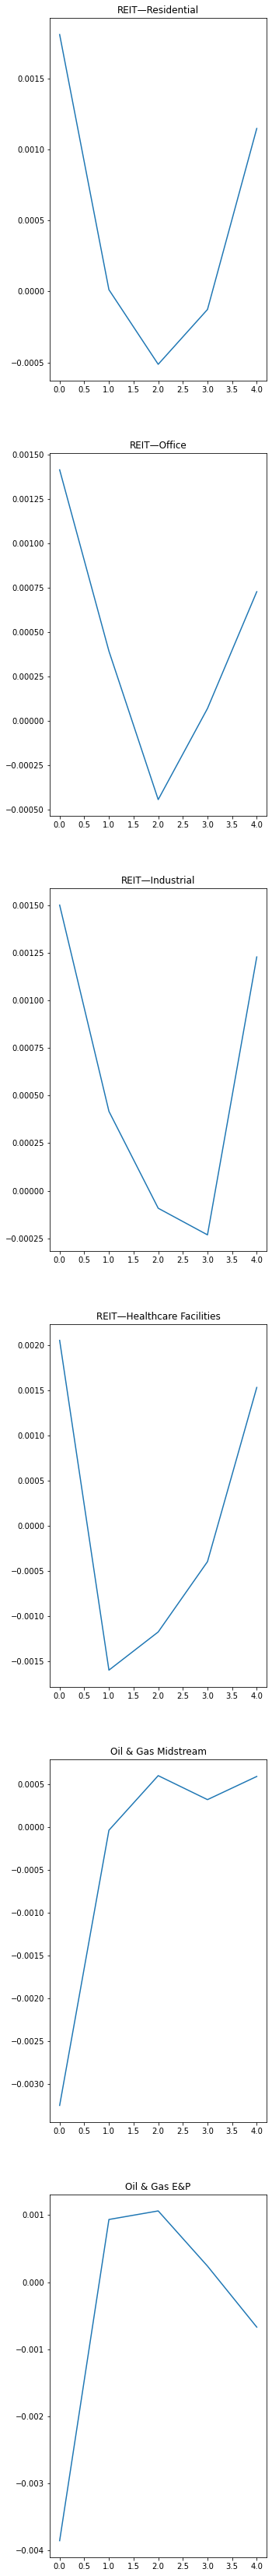

In [34]:
sigDifIndust = ["REIT—Residential", "REIT—Office", "REIT—Industrial", "REIT—Healthcare Facilities", "Oil & Gas Midstream", "Oil & Gas E&P"]

fig, ax = plt.subplots(len(sigDifIndust), 1, figsize=(5,60))
#plt.title("Average Returns by Day by Industry")

## Write a for loop
#for i in range(1,13):
    #temp_mean_per_stock = mean_per_stock_months_and_days.iloc[mean_per_stock_months_and_days.index.get_level_values('Month of Year') == i]
    #ax[i-1].plot(range(1,6), np.mean(temp_mean_per_stock, axis = 1).values)
    #ax[i-1].set_title('Month %i' % (i))

for i in range(len(sigDifIndust)):
    ind = np.argwhere(industries==sigDifIndust[i])[0][0]
    ax[i].plot(range(0, 5), np.mean(meanByDayIndustry[ind], axis = 1))
    ax[i].set_title(sigDifIndust[i])
    #np.mean(meanByDayIndustry[ind], axis = 1).plot()
    #plt.title(sigDifIndust[i])
    #plt.xticks([0, 1, 2, 3, 4], ["Mon", "Tues", "Wed", "Thurs", "Fri"], rotation='horizontal')

For Oil & Gas E&P and Oil & Gas Midstream, the average returns on Monday are significantly lower, indicating a possible Monday effect in these industries.

Do the same thing with month:

In [35]:
dataByIndustryMonth = []

for i in range(len(industries)):
    temp = multilevelLog.iloc[:, multilevelLog.columns.get_level_values(0) == industries[i]]
    temp.index = pd.to_datetime(temp.index)
    temp['month'] = temp.index.month.values
    dataByIndustryMonth.append(temp)

<ipython-input-35-2fadfa1f194b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['month'] = temp.index.month.values


In [36]:
groupeddataMonth = []

for i in range(len(industries)):
    groupedtemp = dataByIndustryMonth[i].groupby('month')
    meantemp = groupedtemp.mean()
    groupeddataMonth.append(meantemp)

In [37]:
pvalues = []
tukeyMonth = []
sigIndustriesByMonth = []
notSigIndustriesByMonth = []

for i in range(len(industries)):
    mean_per_stock_month = groupeddataMonth[i]
    fval, pval = stats.f_oneway(np.array(mean_per_stock_month.iloc[0].array), np.array(mean_per_stock_month.iloc[1].array), np.array(mean_per_stock_month.iloc[2].array), np.array(mean_per_stock_month.iloc[3].array), np.array(mean_per_stock_month.iloc[4].array),np.array(mean_per_stock_month.iloc[5].array), np.array(mean_per_stock_month.iloc[6].array), np.array(mean_per_stock_month.iloc[7].array), np.array(mean_per_stock_month.iloc[8].array), np.array(mean_per_stock_month.iloc[9].array), np.array(mean_per_stock_month.iloc[10].array), np.array(mean_per_stock_month.iloc[11].array))
    pvalues.append(pval)
    if pval < 0.05:
        print(industries[i])
        sigIndustriesByMonth.append(industries[i])
        dfTukey = pd.DataFrame({'return': np.reshape(mean_per_stock_month.values, -1),
                   'month': np.repeat(mean_per_stock_month.index, repeats=len(mean_per_stock_month.iloc[1,:]))})
        tukey = pairwise_tukeyhsd(endog=dfTukey["return"], groups = dfTukey["month"], alpha = 0.05)
        print(tukey)
        tukeyMonth.append(tukey)
    else:
        notSigIndustriesByMonth.append(industries[i])

Advertising Agencies
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0039  0.001  0.0017  0.0061   True
     1      3    0.002 0.0941 -0.0002  0.0043  False
     1      4   0.0002    0.9 -0.0021  0.0024  False
     1      5    0.003 0.0064  0.0007  0.0052   True
     1      6   0.0006    0.9 -0.0017  0.0028  False
     1      7   0.0015 0.3827 -0.0008  0.0037  False
     1      8     -0.0    0.9 -0.0023  0.0022  False
     1      9    0.001  0.785 -0.0012  0.0032  False
     1     10   0.0026 0.0176  0.0004  0.0049   True
     1     11   0.0038  0.001  0.0016  0.0061   True
     1     12   0.0019 0.1186 -0.0003  0.0042  False
     2      3  -0.0019 0.1353 -0.0041  0.0004  False
     2      4  -0.0037  0.001  -0.006 -0.0015   True
     2      5  -0.0009 0.8658 -0.0032  0.0013  False
     2      6  -0.0033 0.0025 -0.0056 -0.0011   True
     2      7  -0.0024 0.

/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3620: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2   0.0072  0.001  0.0036  0.0109   True
     1      3   0.0056  0.001   0.002  0.0093   True
     1      4   0.0048 0.0037  0.0012  0.0085   True
     1      5   0.0046 0.0062  0.0009  0.0083   True
     1      6   0.0032 0.1363 -0.0005  0.0068  False
     1      7   0.0049 0.0033  0.0012  0.0085   True
     1      8   0.0045 0.0076  0.0008  0.0082   True
     1      9    0.003 0.1819 -0.0007  0.0067  False
     1     10   0.0055  0.001  0.0018  0.0092   True
     1     11   0.0052 0.0015  0.0015  0.0089   True
     1     12   0.0039 0.0335  0.0002  0.0075   True
     2      3  -0.0016    0.9 -0.0053  0.0021  False
     2      4  -0.0024 0.4748 -0.0061  0.0013  False
     2      5  -0.0026 0.3493 -0.0063  0.0011  False
     2      6  -0.0041  0.022 -0.0077 -0.0004   True
     2      7  -0.0024 0.4972  -0.006  0.0013 

Once again, we identify the industries were Januarys were significantly different than other months at higher rates. These industries are REIT-Retail, Packaging & Containers, Oil & Gas Integrated, Integrated Freight & Logistics, Insurance-Property & Casualty, Insurance-Life, Insurance-Diversified, Insurance Brokers, Credit Services, Capital Markets, Banks-Diversified, Auto Parts, Asset Management. Next, we create plots to check if the January returns are significantly different because the mean return of that month is lower.

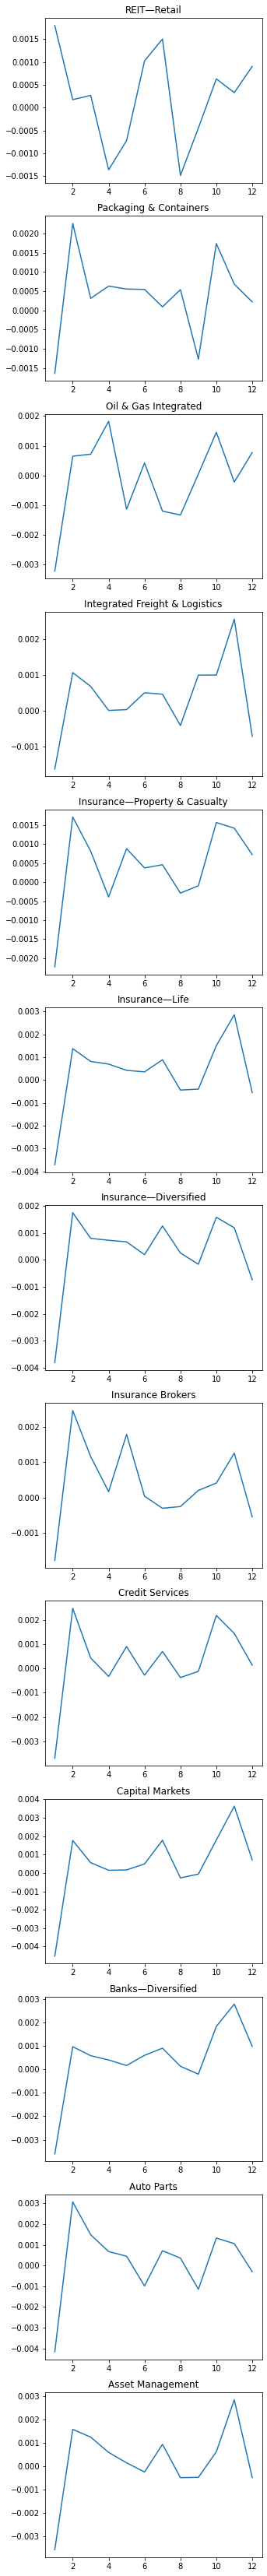

In [38]:
sigDifIndustMonth = ['REIT—Retail', 'Packaging & Containers', 'Oil & Gas Integrated', 'Integrated Freight & Logistics','Insurance—Property & Casualty', 'Insurance—Life', 'Insurance—Diversified', 'Insurance Brokers', 'Credit Services', 'Capital Markets', 'Banks—Diversified', 'Auto Parts', 'Asset Management']

fig, ax = plt.subplots(len(sigDifIndustMonth), 1, figsize = (5,60))

#industries


for i in range(len(sigDifIndustMonth)):
    ind = np.argwhere(industries==sigDifIndustMonth[i])[0][0]
    ax[i].plot(range(1, 13), np.mean(groupeddataMonth[ind], axis = 1))
    ax[i].set_title(sigDifIndustMonth[i])

All industries except REIT-Retail have lower January average returns.

Although we have found a few industries where the Monday effect seems to occur on both a daily (with Mondays tending to have lower returns) and monthly (with Januarys tending to have lower returns) basis, one important note is that if we subset enough industries, then we are bound to find some industries that appear to have a Monday effect, regardless of if there is any real underlying cause that leads to Mondays having a strong effect on the stock market. If a good portion of industries tested have observed Monday effects, then we can hypothesize that the Monday effect has a significant effect on the market.

On a daily basis...

In [41]:
len(sigDifIndust)/len(industries)

0.05172413793103448

...only around 5% of industries have significantly different Monday returns. Even fewer have significantly lower Monday returns.

On a monthly basis...

In [42]:
len(sigDifIndustMonth)/len(industries)

0.11206896551724138

...only around 11% of industries have significantly different Monday returns. Even fewer have significantly lower Monday returns.